In [1]:
import ee
import geemap
import datetime

import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
m = geemap.Map()

Enter verification code: 4/1AVHEtk5HZ0dxZEaLqZAHjXRWg3mDj-6VQxxAjgLSFCG2JZbRPPMVsfuXELs

Successfully saved authorization token.


In [4]:
# Area of interest. Defined by a polygon

# AWD in day 3 site. apply water every 6 days
geometry = ee.Geometry.Polygon([
  [89.00239529326589, 23.363047351642273],
  [89.00177838519247, 23.363022728677635],
  [89.001874944717, 23.362623836013544],
  [89.00238456442983, 23.362658308266433],
  [89.00239529326589, 23.363047351642273]
]);


In [8]:
m.add_basemap('HYBRID')
m.centerObject(geometry, zoom=17)
m.addLayer(geometry, {'color': 'red'}, 'Polygon')

m

Map(bottom=7268631.0, center=[23.362844116577374, 89.00210579267959], controls=(WidgetControl(options=['positi…

In [9]:
area_m2 = geometry.area()
area_ha = area_m2.divide(10000)  # Convert to hectares

In [44]:
area_ha.getInfo()*4

1.0132738366743368

In [31]:
def meth_calc(area_ha_in, mon_season=3, paddy_repeat=1):
    area_ha = area_ha_in * paddy_repeat
    
    EF_annual = 0.8  # Annual emission factor (CH4 kg/ha/yr)
    EF_months = EF_annual * (mon_season / 12)  # Adjusted emission factor for the growing season
    R = 0.48  # Reduction factor for intermittent flooding (AWD)

    CH4_emissions_base_months = area_ha * EF_months
    CH4_emissions_AWD_months = area_ha * EF_months * (1 - R)

    return area_ha, CH4_emissions_base_months, CH4_emissions_AWD_months

In [45]:
# Calculate the area in hectares
area_ha_in = area_ha.getInfo()

# Call the meth_calc function with the area in hectares and the respective paddy_repeat values
area_ha_year1, CH4_emissions_base_year1, CH4_emissions_AWD_year1 = meth_calc(area_ha_in, paddy_repeat=4)
area_ha_year2, CH4_emissions_base_year2, CH4_emissions_AWD_year2 = meth_calc(area_ha_in, paddy_repeat=20)


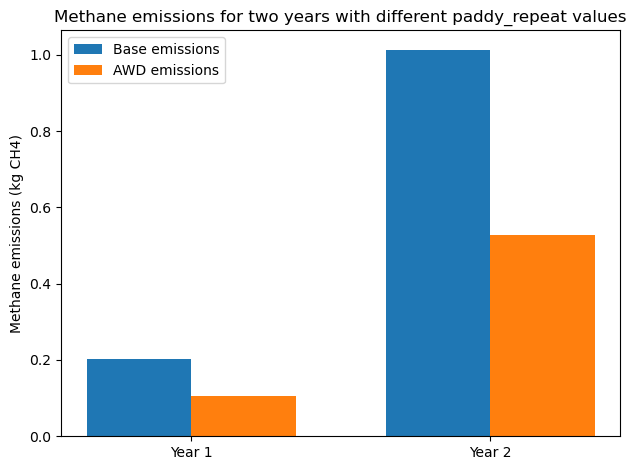

In [46]:
import matplotlib.pyplot as plt
import numpy as np

years = ['Year 1', 'Year 2']
base_emissions = [CH4_emissions_base_year1, CH4_emissions_base_year2]
awd_emissions = [CH4_emissions_AWD_year1, CH4_emissions_AWD_year2]

x = np.arange(len(years))  # The x-axis locations for the groups
width = 0.35  # The width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_emissions, width, label='Base emissions')
rects2 = ax.bar(x + width/2, awd_emissions, width, label='AWD emissions')

ax.set_ylabel('Methane emissions (kg CH4)')
ax.set_title('Methane emissions for two years with different paddy_repeat values')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()
plt.show()


In [38]:
CH4_to_CO2e = 28  # Global Warming Potential (GWP) of methane over a 100-year time horizon
carbon_price = 40  # Carbon price in $/ton

# Calculate the equivalent tCO2 reduction for each year
tCO2_reduction_year1 = (CH4_emissions_base_year1 - CH4_emissions_AWD_year1) * CH4_to_CO2e / 1000  # Convert kg to tons
tCO2_reduction_year2 = (CH4_emissions_base_year2 - CH4_emissions_AWD_year2) * CH4_to_CO2e / 1000

# Calculate the monetary value of the emissions reduction for each year
value_year1 = tCO2_reduction_year1 * carbon_price
value_year2 = tCO2_reduction_year2 * carbon_price


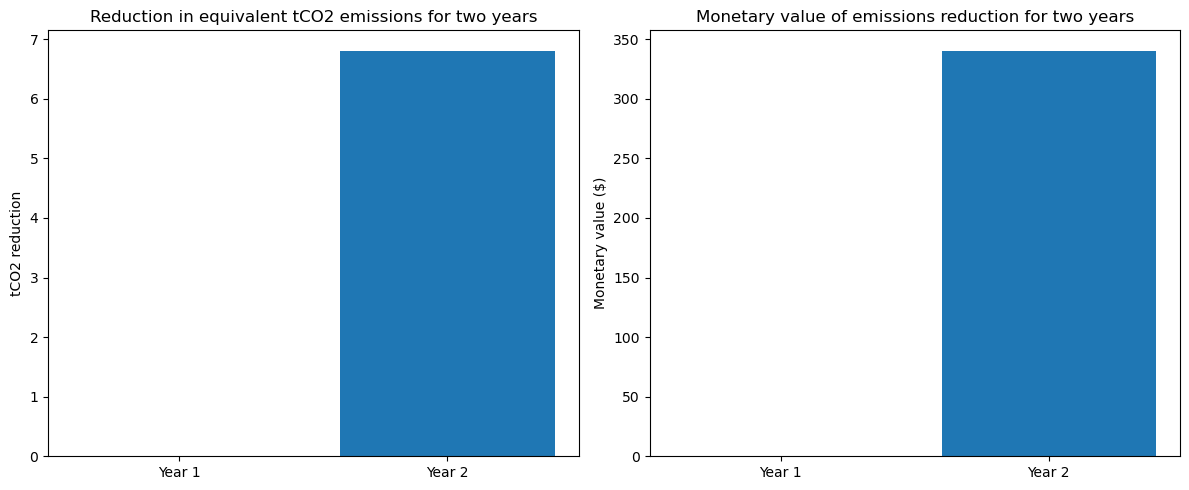

In [39]:
# Plot the tCO2 reduction for the two years
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

tCO2_reduction = [tCO2_reduction_year1, tCO2_reduction_year2]
rects_tCO2 = ax1.bar(years, tCO2_reduction)

ax1.set_ylabel('tCO2 reduction')
ax1.set_title('Reduction in equivalent tCO2 emissions for two years')
ax1.set_xticklabels(years)

# Plot the monetary value for the two years
monetary_value = [value_year1, value_year2]
rects_value = ax2.bar(years, monetary_value)

ax2.set_ylabel('Monetary value ($)')
ax2.set_title('Monetary value of emissions reduction for two years')
ax2.set_xticklabels(years)

fig.tight_layout()
plt.show()
